##### Copyright 2020 The Cirq Developers

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cirq basics

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/basics"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/basics.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/basics.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/basics.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This tutorial will teach the basics of how to use Cirq.  This tutorial will walk through how to use qubits, gates, and operations to create and simulate your first quantum circuit using Cirq.  It will briefly introduce devices, unitary matrices, decompositions, and optimizers.

This tutorial isn’t a quantum computing 101 tutorial, we assume familiarity of quantum computing at about the level of the textbook “Quantum Computation and Quantum Information” by Nielsen and Chuang.

For more in-depth examples closer to those found in current work, check out our tutorials page.

To begin, please follow the instructions for [installing Cirq](../install.md).

In [ ]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

## Qubits

The first part of creating a quantum circuit is to define a set of qubits (also known as a quantum registers) to act on.

Cirq has three main ways of defining qubits:

*   `cirq.NamedQubit`: used to label qubits by an abstract name
*   `cirq.LineQubit`: qubits labelled by number in a linear array 
*   `cirq.GridQubit`: qubits labelled by two numbers in a rectangular lattice.

Here are some examples of defining each type of qubit.

In [ ]:
import cirq
import cirq_google

# Using named qubits can be useful for abstract algorithms
# as well as algorithms not yet mapped onto hardware.
q0 = cirq.NamedQubit('source')
q1 = cirq.NamedQubit('target')

# Line qubits can be created individually
q3 = cirq.LineQubit(3)

# Or created in a range
# This will create LineQubit(0), LineQubit(1), LineQubit(2)
q0, q1, q2 = cirq.LineQubit.range(3)

# Grid Qubits can also be referenced individually
q4_5 = cirq.GridQubit(4,5)

# Or created in bulk in a square
# This will create 16 qubits from (0,0) to (3,3)
qubits = cirq.GridQubit.square(4)

There are also pre-packaged sets of qubits called [Devices](../devices.md).  These are qubits along with a set of rules of how they can be used.  A `cirq.Device` can be used to apply adjacency rules and other hardware constraints to a quantum circuit.  For our example, we will use the `cirq_google.Foxtail` device that comes with cirq.  It is a 2x11 grid that mimics early hardware released by Google.

In [ ]:
print(cirq_google.Foxtail)

(0, 0)───(0, 1)───(0, 2)───(0, 3)───(0, 4)───(0, 5)───(0, 6)───(0, 7)───(0, 8)───(0, 9)───(0, 10)
│        │        │        │        │        │        │        │        │        │        │
│        │        │        │        │        │        │        │        │        │        │
(1, 0)───(1, 1)───(1, 2)───(1, 3)───(1, 4)───(1, 5)───(1, 6)───(1, 7)───(1, 8)───(1, 9)───(1, 10)


## Gates and operations

The next step is to use the qubits to create operations that can be used in our circuit.  Cirq has two concepts that are important to understand here:

*   A `Gate` is an effect that can be applied to a set of qubits.  
*   An `Operation` is a gate applied to a set of qubits.

For instance, `cirq.H` is the quantum [Hadamard](https://en.wikipedia.org/wiki/Quantum_logic_gate#Hadamard_(H)_gate) and is a `Gate` object.  `cirq.H(cirq.LineQubit(1))` is an `Operation` object and is the Hadamard gate applied to a specific qubit (line qubit number 1).

Many textbook gates are included within cirq.  `cirq.X`, `cirq.Y`, and `cirq.Z` refer to the single-qubit Pauli gates.  `cirq.CZ`, `cirq.CNOT`, `cirq.SWAP` are a few of the common two-qubit gates.  `cirq.measure` is a macro to apply a `MeasurementGate` to a set of qubits.  You can find more, as well as instructions on how to creats your own custom gates, on the [Gates documentation](../gates.ipynb) page.

Many arithmetic operations can also be applied to gates.  Here are some examples:

In [ ]:
# Example gates
not_gate = cirq.CNOT
pauli_z = cirq.Z

# Using exponentiation to get square root gates
sqrt_x_gate = cirq.X**0.5

# Some gates can also take parameters
sqrt_sqrt_y = cirq.YPowGate(exponent=0.25)

# Example operations
q0, q1 = cirq.LineQubit.range(2)
z_op = cirq.Z(q0)
not_op = cirq.CNOT(q0, q1)
sqrt_iswap_op = cirq.SQRT_ISWAP(q0, q1)

## Circuits and moments

We are now ready to construct a quantum circuit.  A `Circuit` is a collection of `Moment`s. A `Moment` is a collection of `Operation`s that all act during the same abstract time slice.  Each `Operation` must have a disjoint set of qubits from the other `Operation`s in the `Moment`.  A `Moment` can be thought of as a vertical slice of a quantum circuit diagram.

Circuits can be constructed in several different ways.  By default, cirq will attempt to slide your operation into the earliest possible `Moment` when you insert it.


In [ ]:
circuit = cirq.Circuit()
# You can create a circuit by appending to it
circuit.append(cirq.H(q) for q in cirq.LineQubit.range(3))
# All of the gates are put into the same Moment since none overlap
print(circuit)

0: ───H───

1: ───H───

2: ───H───


In [ ]:
# We can also create a circuit directly as well:
print(cirq.Circuit(cirq.SWAP(q, q+1) for q in cirq.LineQubit.range(3)))

0: ───×───────────
      │
1: ───×───×───────
          │
2: ───────×───×───
              │
3: ───────────×───


Sometimes, you may not want cirq to automatically shift operations all the way to the left.  To construct a circuit without doing this, you can create the circuit moment-by-moment or use a different `InsertStrategy`, explained more in the [Circuit documentation](../circuits.ipynb).

In [ ]:
# Creates each gate in a separate moment.
print(cirq.Circuit(cirq.Moment([cirq.H(q)]) for q in cirq.LineQubit.range(3)))

0: ───H───────────

1: ───────H───────

2: ───────────H───


### Circuits and devices

One important consideration when using real quantum devices is that there are often hardware constraints on the circuit.  Creating a circuit with a `Device` will allow you to capture some of these requirements.  These `Device` objects will validate the operations you add to the circuit to make sure that no illegal operations are added.

Let's look at an example using the Foxtail device.

In [ ]:
q0 = cirq.GridQubit(0, 0)
q1 = cirq.GridQubit(0, 1)
q2 = cirq.GridQubit(0, 2)
adjacent_op = cirq.CZ(q0, q1)
nonadjacent_op = cirq.CZ(q0, q2)

# This is an unconstrained circuit with no device
free_circuit = cirq.Circuit()
# Both operations are allowed:
free_circuit.append(adjacent_op)
free_circuit.append(nonadjacent_op)
print('Unconstrained device:')
print(free_circuit)
print()

# This is a circuit on the Foxtail device
# only adjacent operations are allowed.
print('Foxtail device:')
foxtail_circuit = cirq.Circuit(device=cirq_google.Foxtail)
foxtail_circuit.append(adjacent_op)
try:
    # Not allowed, will throw exception
    foxtail_circuit.append(nonadjacent_op)
except ValueError as e:
    print('Not allowed. %s' % e)


Unconstrained device:
(0, 0): ───@───@───
           │   │
(0, 1): ───@───┼───
               │
(0, 2): ───────@───

Foxtail device:
Not allowed. Non-local interaction: cirq.CZ.on(cirq.GridQubit(0, 0), cirq.GridQubit(0, 2)).


## Simulation

The results of the application of a quantum circuit can be calculated by a `Simulator`.  Cirq comes bundled with a simulator that can calculate the results of circuits up to about a limit of 20 qubits.  It can be initialized with `cirq.Simulator()`.

There are two different approaches to using a simulator:

*   `simulate()`:  Since we are classically simulating a circuit, a simulator can directly access and view the resulting wave function.  This is useful for debugging, learning, and understanding how circuits will function.  
*   `run()`:  When using actual quantum devices, we can only access the end result of a computation and must sample the results to get a distribution of results.  Running the simulator as a sampler mimics this behavior and only returns bit strings as output.

Let's try to simulate a 2-qubit "Bell State":

In [ ]:
# Create a circuit to generate a Bell State:
# 1/sqrt(2) * ( |00⟩ + |11⟩ )
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0,q1))

# Initialize Simulator
s=cirq.Simulator()

print('Simulate the circuit:')
results=s.simulate(bell_circuit)
print(results)
print()

# For sampling, we need to add a measurement at the end
bell_circuit.append(cirq.measure(q0, q1, key='result'))

print('Sample the circuit:')
samples=s.run(bell_circuit, repetitions=1000)
# Print a histogram of results
print(samples.histogram(key='result'))

Simulate the circuit:
measurements: (no measurements)
output vector: 0.707|00⟩ + 0.707|11⟩

Sample the circuit:
Counter({3: 537, 0: 463})


### Using parameter sweeps

Cirq circuits allow for gates to have symbols as free parameters within the circuit.  This is especially useful for variational algorithms, which vary parameters within the circuit in order to optimize a cost function, but it can be useful in a variety of circumstances.

For parameters, cirq uses the library `sympy` to add `sympy.Symbol` as parameters to gates and operations.  

Once the circuit is complete, you can fill in the possible values of each of these parameters with a `Sweep`.  There are several possibilities that can be used as a sweep:

*   `cirq.Points`: A list of manually specified values for one specific symbol as a sequence of floats
*   `cirq.Linspace`: A linear sweep from a starting value to an ending value.
*   `cirq.ListSweep`: A list of manually specified values for several different symbols, specified as a list of dictionaries.
*   `cirq.Zip` and `cirq.Product`: Sweeps can be combined list-wise by zipping them together or through their Cartesian product.

A parameterized circuit and sweep together can be run using the simulator or other sampler by changing `run()` to `run_sweep()` and adding the sweep as a parameter.

Here is an example of sweeping an exponent of a X gate:

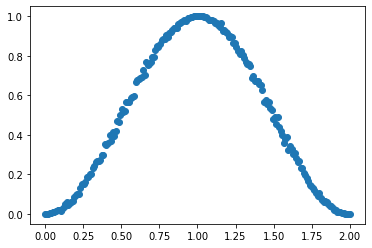

In [ ]:
import matplotlib.pyplot as plt
import sympy

# Perform an X gate with variable exponent
q = cirq.GridQubit(1,1)
circuit = cirq.Circuit(cirq.X(q) ** sympy.Symbol('t'),
                       cirq.measure(q, key='m'))

# Sweep exponent from zero (off) to one (on) and back to two (off)
param_sweep = cirq.Linspace('t', start=0, stop=2, length=200)

# Simulate the sweep
s = cirq.Simulator()
trials = s.run_sweep(circuit, param_sweep, repetitions=1000)

# Plot all the results
x_data = [trial.params['t'] for trial in trials]
y_data = [trial.histogram(key='m')[1] / 1000.0 for trial in trials]
plt.scatter('t','p', data={'t': x_data, 'p': y_data})


## Unitary matrices and decompositions

Most quantum operations have a unitary matrix representation.  This matrix can be accessed by applying `cirq.unitary()`.  This can be applied to gates, operations, and circuits that support this protocol and will return the unitary matrix that represents the object.

In [ ]:
print('Unitary of the X gate')
print(cirq.unitary(cirq.X))

print('Unitary of SWAP operator on two qubits.')
q0, q1 = cirq.LineQubit.range(2)
print(cirq.unitary(cirq.SWAP(q0, q1)))

print('Unitary of a sample circuit')
print(cirq.unitary(cirq.Circuit(cirq.X(q0), cirq.SWAP(q0, q1))))

Unitary of the X gate
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Unitary of SWAP operator on two qubits.
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Unitary of a sample circuit
[[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


### Decompositions 

Many gates can be decomposed into an equivalent circuit with simpler operations and gates.  This is called decomposition and can be accomplished with the `cirq.decompose` protocol.  

For instance, a Hadamard H gate can be decomposed into X and Y gates:

In [ ]:
print(cirq.decompose(cirq.H(cirq.LineQubit(0))))

[(cirq.Y**0.5).on(cirq.LineQubit(0)), cirq.XPowGate(exponent=1.0, global_shift=-0.25).on(cirq.LineQubit(0))]


Another example is the 3-qubit Toffoli gate, which is equivalent to a controlled-controlled-X gate.  Many devices do not support a three qubit gate, so it is important 

In [ ]:
q0, q1, q2 = cirq.LineQubit.range(3)
print(cirq.Circuit(cirq.decompose(cirq.TOFFOLI(q0, q1, q2))))

0: ───T────────────────@─────────────────────────────────@─────────────────────────────@────────────────────────────@───────────────────────────────────────
                       │                                 │                             │                            │
1: ───T───────Y^-0.5───@───Y^0.5────@───T^-1────Y^-0.5───@────────Y^0.5───@───Y^-0.5───@──────Y^0.5────@───Y^-0.5───@──────Y^0.5────@───────────────────────
                                    │                                     │                            │                            │
2: ───Y^0.5───X────────T───Y^-0.5───@───Y^0.5───T────────Y^-0.5───────────@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5───Y^0.5───X───


The above decomposes the Toffoli into a simpler set of one-qubit gates and CZ gates at the cost of lengthening the circuit considerably.

Some devices will automatically decompose gates that they do not support.  For instance, if we use the `Foxtail` device from above, we can see this in action by adding an unsupported SWAP gate:

In [ ]:
swap = cirq.SWAP(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1))
print(cirq.Circuit(swap, device=cirq_google.Foxtail))

(0, 0): ───S^-1───Y^-0.5───@───S^-1───Y^0.5───X^0.5───@───S^-1───X^-0.5───@───S^-1───Z───
                           │                          │                   │
(0, 1): ───Z──────Y^-0.5───@───S^-1───Y^0.5───X^0.5───@───S^-1───X^-0.5───@───S^-1───S───


### Optimizers

The last concept in this tutorial is the optimizer.  An optimizer can take a circuit and modify it.  Usually, this will entail combining or modifying operations to make it more efficient and shorter, though an optimizer can, in theory, do any sort of circuit manipulation.

For example, the `MergeSingleQubitGates` optimizer will take consecutive single-qubit operations and merge them into a single `PhasedXZ` operation.

In [ ]:
q=cirq.GridQubit(1, 1)
optimizer=cirq.MergeSingleQubitGates()
c=cirq.Circuit(cirq.X(q) ** 0.25, cirq.Y(q) ** 0.25, cirq.Z(q) ** 0.25)
print(c)
optimizer.optimize_circuit(c)
print(c)

(1, 1): ───X^0.25───Y^0.25───T───
           ┌                           ┐
(1, 1): ───│ 0.5  +0.707j -0.   -0.5j  │───────────
           │ 0.354+0.354j  0.146+0.854j│
           └                           ┘


Other optimizers can assist in transforming a circuit into operations that are native operations on specific hardware devices.  You can find more about optimizers and how to create your own elsewhere in the documentation.

## Next steps

After completing this tutorial, you should be able to use gates and operations to construct your own quantum circuits, simulate them, and to use sweeps.  It should give you a brief idea of the commonly used 

There is much more to learn and try out for those who are interested:

* Learn about the variety of [Gates](../gates.ipynb) available in cirq and more about the different ways to construct [Circuits](../circuits.ipynb)
* Learn more about [Simulations](../simulation.ipynb) and how it works.
* Learn about [Noise](../noise.ipynb) and how to utilize multi-level systems using [Qudits](../qudits.ipynb)
* Dive into some [Examples](_index.yaml) and some in-depth tutorials of how to use cirq.

Also, join our [cirq-announce mailing list](https://groups.google.com/forum/#!forum/cirq-announce) to hear about changes and releases or go to the [cirq github](https://github.com/quantumlib/Cirq/) to file issues.